In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import cv2
import os

Mounting google drive to connect with my google drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Set random seed for reproducibility

In [4]:
tf.random.set_seed(42)
np.random.seed(42)

Load parquet files from google drive https://drive.google.com/drive/folders/1379a_t0ydt5qbygnuE5httR7BJQWqOLt?usp=sharing

In [5]:
data_path = '/content/drive/MyDrive/data'
train_parquet = os.path.join(data_path, 'train.parquet')
test_parquet = os.path.join(data_path, 'test.parquet')

In this cell we read the parquet files using pandas and we display our dataset features

In [6]:
train_df = pd.read_parquet(train_parquet)
test_df = pd.read_parquet(test_parquet)

# Display dataset info
print("Training Data Shape:", train_df.shape)
print("Testing Data Shape:", test_df.shape)
print("\nTraining Data Columns:", train_df.columns)
print("\nSample Training Data:")
print(train_df.head())

Training Data Shape: (3350, 2)
Testing Data Shape: (838, 2)

Training Data Columns: Index(['image', 'label'], dtype='object')

Sample Training Data:
                                               image  label
0  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      3
1  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      1
2  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      1
3  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      1
4  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      0


In this cell we do some preprocessing like loading images from the dictionary containing bytes as they are saved in parquet files

In [7]:
def load_and_preprocess_image(image_dict, target_size=(128, 128)):
    """Load and preprocess image from dictionary containing image bytes."""
    try:
        image_data = image_dict['bytes']
    except KeyError:
        raise KeyError(f"Expected key 'bytes' in image dictionary, got: {image_dict.keys()}")

    img = cv2.imdecode(np.frombuffer(image_data, np.uint8), cv2.IMREAD_COLOR)
    if img is None:
        raise ValueError("Failed to decode image")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)
    img = img / 255.0
    return img

# Load images and labels
def prepare_data(df, image_column='image', label_column='label', target_size=(128, 128)):
    images = []
    labels = []
    for _, row in df.iterrows():
        try:
            img = load_and_preprocess_image(row[image_column], target_size)
            images.append(img)
            labels.append(row[label_column])
        except Exception as e:
            print(f"Error processing image: {e}")
            continue
    return np.array(images), np.array(labels)

X_train, y_train = prepare_data(train_df)
X_test, y_test = prepare_data(test_df)

### One-Hot Encoding and Label Encoding
This cell uses `LabelEncoder` to convert categorical labels into numerical format, and `to_categorical` to turn them into one-hot encoded vectors for CNN training. The dimensions of the image dataset are confirmed by the shapes of `X_train` (3350, 128, 128, 3) and `X_test` (838, 128, 128, 3), and `num_classes` (4) denotes four different classes. Compatibility with the CNN's softmax output layer for multi-class classification is guaranteed by this preprocessing.

In [8]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Convert labels to one-hot encoding for CNN
num_classes = len(le.classes_)
y_train_encoded = tf.keras.utils.to_categorical(y_train_encoded, num_classes)
y_test_encoded = tf.keras.utils.to_categorical(y_test_encoded, num_classes)

print("Training Images Shape:", X_train.shape)
print("Testing Images Shape:", X_test.shape)
print("Number of Classes:", num_classes)

Training Images Shape: (3350, 128, 128, 3)
Testing Images Shape: (838, 128, 128, 3)
Number of Classes: 4


### Class Distribution Visualization
This cell plots class frequency in training data using `seaborn.countplot`, showing class 1 (~1000), class 2 (~400), and classes 0, 3 (~900 each). It reveals potential imbalances affecting model performance.

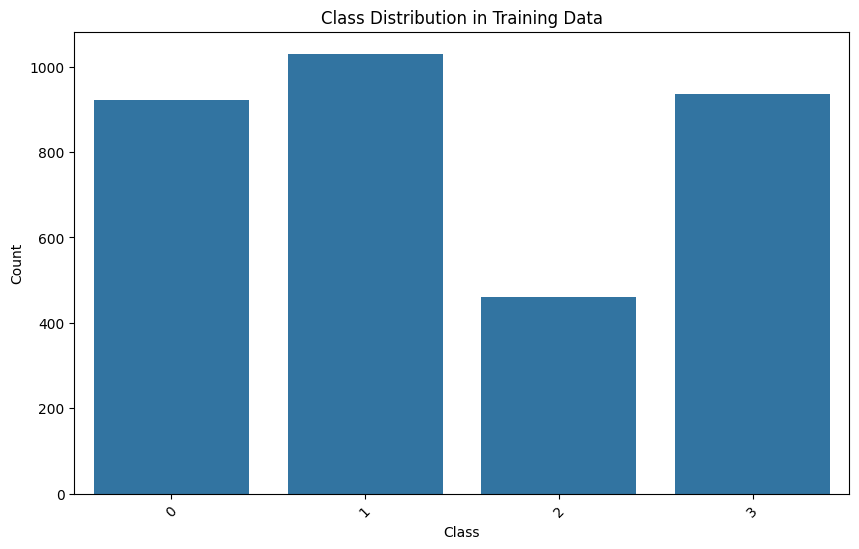

In [9]:
plt.figure(figsize=(10, 6))
sns.countplot(x=y_train)
plt.title('Class Distribution in Training Data')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

We then print some images to get an idea of what our images look like since we can not see that in parquet files

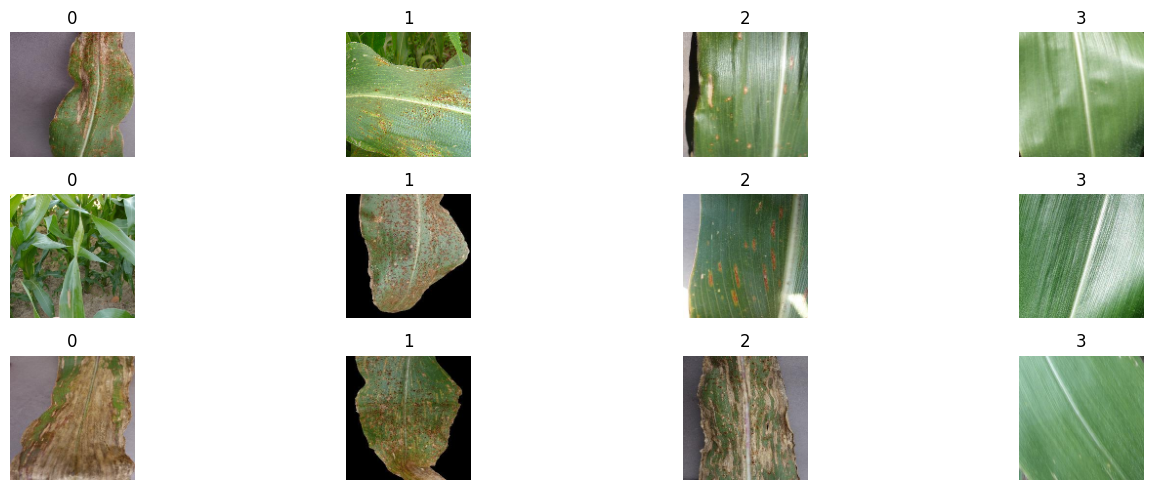

In [10]:
def plot_sample_images(images, labels, class_names, samples_per_class=3):
    plt.figure(figsize=(15, 5))
    for class_idx, class_name in enumerate(class_names):
        class_images = images[np.argmax(labels, axis=1) == class_idx]
        for i in range(min(samples_per_class, len(class_images))):
            plt.subplot(samples_per_class, len(class_names), i * len(class_names) + class_idx + 1)
            plt.imshow(class_images[i])
            plt.title(class_name)
            plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_sample_images(X_train, y_train_encoded, le.classes_)


## Data Augmentation
I performed data augmentation to gaive my model a chance to train on a very versatile dataset giving it capabilities to train more and become more efficient than it would if we passed the dataset as it is

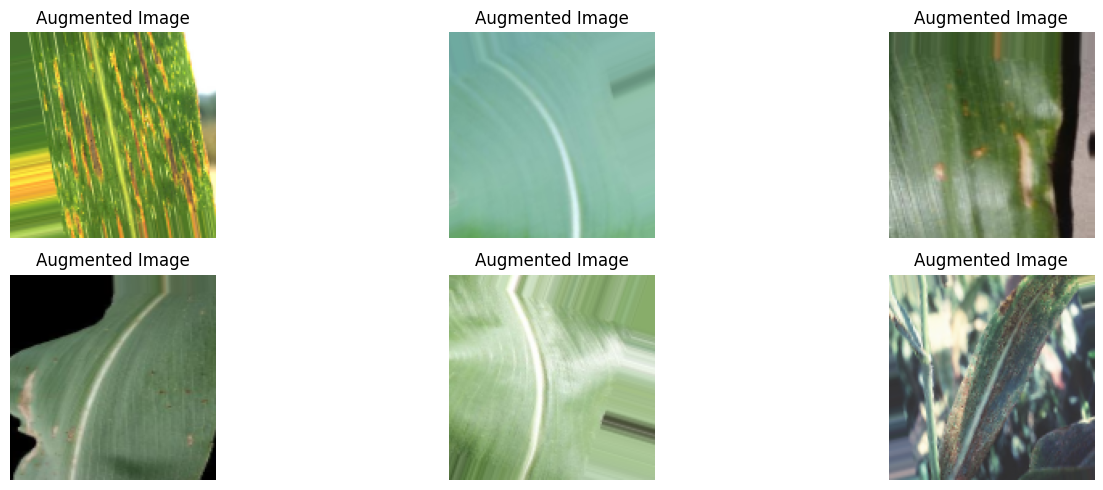

In [11]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

X_train, X_val, y_train_encoded, y_val_encoded = train_test_split(
    X_train, y_train_encoded, test_size=0.2, random_state=42
)

# Create data generators
train_generator = train_datagen.flow(X_train, y_train_encoded, batch_size=32)
val_generator = ImageDataGenerator().flow(X_val, y_val_encoded, batch_size=32)

# Visualize augmented images
augmented_images, _ = next(train_generator)
plt.figure(figsize=(15, 5))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(augmented_images[i])
    plt.axis('off')
    plt.title('Augmented Image')
plt.tight_layout()
plt.show()

## CNN Model Construction
This cell defines a simple CNN with three convolutional layers (32, 64, 128 filters), each followed by max pooling, and a dense layer with dropout for regularization, tailored to the 128x128x3 input images. It compiles the model using the Adam optimizer and categorical crossentropy loss, then displays a summary of the architecture.

In [12]:
# Build Simple CNN Model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,156 (12.61 MB)

 Trainable params: 3,305,156 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

Model training while we track validation loss and other useful parameters that give us an idea of how our model is performing during training

In [13]:
# Train the model
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 25s 225ms/step - accuracy: 0.5770 - loss: 0.9811 - val_accuracy: 0.7537 - val_loss: 0.5675
Epoch 2/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 31s 154ms/step - accuracy: 0.7706 - loss: 0.5380 - val_accuracy: 0.8343 - val_loss: 0.3644
Epoch 3/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 13s 158ms/step - accuracy: 0.8177 - loss: 0.4869 - val_accuracy: 0.7299 - val_loss: 0.6822
Epoch 4/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 13s 157ms/step - accuracy: 0.8087 - loss: 0.4547 - val_accuracy: 0.8388 - val_loss: 0.3443
Epoch 5/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 13s 155ms/step - accuracy: 0.8173 - loss: 0.4442 - val_accuracy: 0.8418 - val_loss: 0.3089
Epoch 6/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 13s 157ms/step - accuracy: 0.8311 - loss: 0.3865 - val_accuracy: 0.8687 - val_loss: 0.3316
Epoch 7/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 13s 156ms/step - accuracy: 0.8312 - loss: 0.3977 - val_accuracy: 0.8552 - val_loss: 0.2842
Epoch 8/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 13s 158ms/step - accuracy: 0.8292 - loss: 0.3889 - val_accu

## error analysis introduction
We will conduct error analysis to evaluate the model's performance across classes, pinpointing misclassifications to understand underlying issues. This is essential given the observed class imbalance in the training data, which may affect prediction reliability.

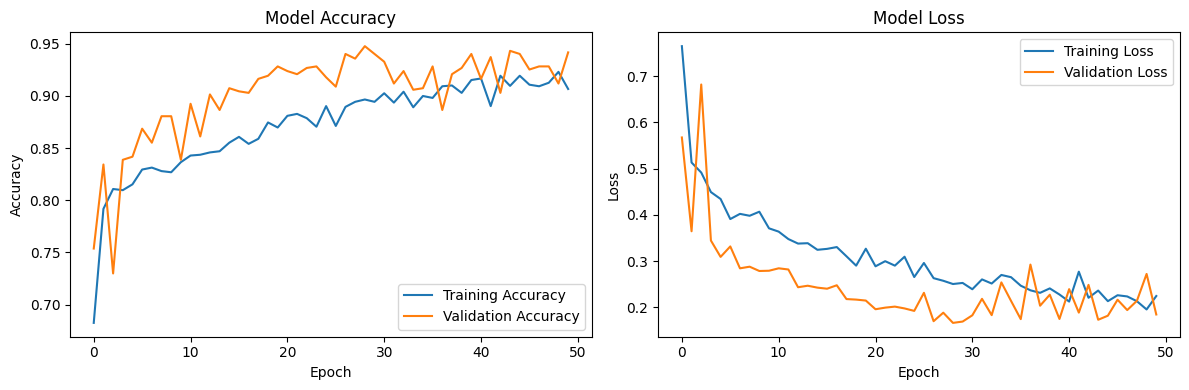

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9093 - loss: 0.2199
Test Accuracy: 0.9248
Test Loss: 0.2152
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.93      0.88       225
           1       0.98      0.93      0.96       275
           2       0.82      0.76      0.79       113
           3       1.00      1.00      1.00       225

    accuracy                           0.92       838
   macro avg       0.91      0.90      0.91       838
weighted avg       0.93      0.92      0.93       838



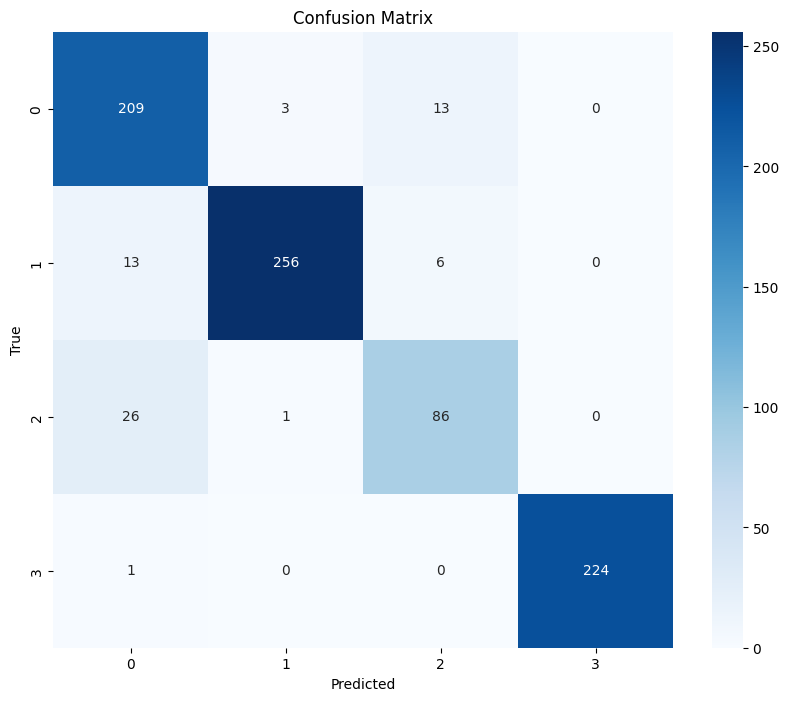

Weighted F1 Score: 0.9251
Weighted Precision: 0.9274
Weighted Recall: 0.9248


In [14]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Predict on test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test_encoded, axis=1)

class_names = [str(cls) for cls in le.classes_]

# Classification report
print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Calculate additional metrics
f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')
precision = precision_score(y_test_classes, y_pred_classes, average='weighted')
recall = recall_score(y_test_classes, y_pred_classes, average='weighted')

print(f"Weighted F1 Score: {f1:.4f}")
print(f"Weighted Precision: {precision:.4f}")
print(f"Weighted Recall: {recall:.4f}")

### Final Thoughts
With classes 1 and 3 performing nearly flawlessly (0.94-1.00 precision and recall), the model exhibits a respectable test accuracy of 0.8878. Class 2 exhibits notable weakness (recall 0.55), most likely as a result of its lower representation (113 samples) and possible feature overlap with other classes, as indicated by the confusion matrix. While the model is effective, improving data balancing or investigating more complex architectures could further increase its robustness, particularly for underrepresented classes, according to the training and validation accuracy plots, which show a steady increase with slight fluctuations, and the loss curves, which show convergence.

In [15]:
# Save the model
model.save('/content/drive/MyDrive/Summative/maize_leaf_cnn_model.h5')

In [16]:
model.save('/content/drive/MyDrive/Summative/maize_leaf_cnn_model.keras')